In [61]:
import osmnx as ox
import networkx as nx
from pathlib import Path
import pandas as pd
from shapely.geometry import box
import random
import osmnx as ox, shapely.geometry as shg

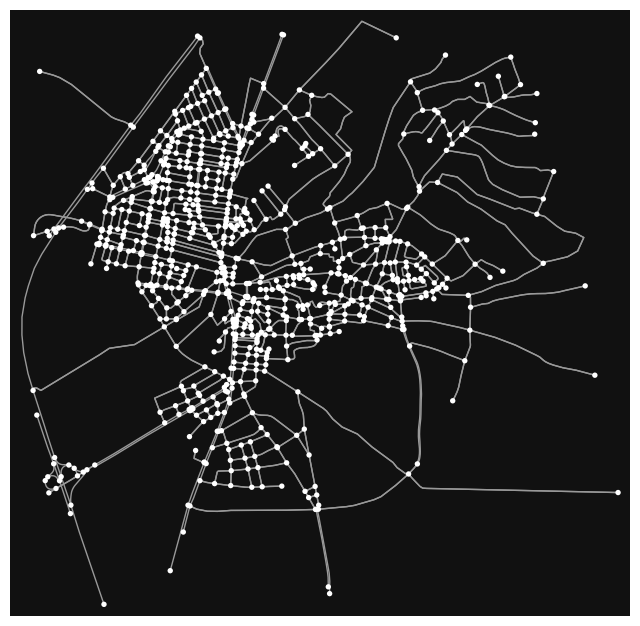

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [62]:
west, south, east, north = 36.71519, 34.00945, 36.74922, 34.03680
poly = box(west, south, east, north)
G = ox.graph_from_polygon(poly,    
                       network_type='drive',
                       retain_all=True,           # ابقِ كل المكوّنات
                       simplify=True,             # تبسيط الهندسة
                       truncate_by_edge=True)     # قصّ الحواف على حدود الـbbox

# عرض سريع (صورة ثابتة)
ox.plot_graph(G)

In [63]:
custom = {
    "motorway":80, "motorway_link":60,
    "trunk":70, "trunk_link":60,
    "primary":60, "primary_link":50,
    "secondary":50, "secondary_link":45,
    "tertiary":40, "tertiary_link":35,
    "residential":30, "living_street":20,
    "service":20, "unclassified":35
}

# fyll saknade hastigheter (behåller maxspeed om den finns)
G = ox.add_edge_speeds(G, hwy_speeds=custom)
G = ox.add_edge_travel_times(G)  # skapar 'travel_time' i sekunder

# (valfritt) stadspåslag för realism (rödljus, svängar)
for _,_,_,d in G.edges(keys=True, data=True):
    d["travel_time"] *= 1.3  # +30%

m = ox.plot_graph_folium(G)
m.save("roads_bbox.html")   # افتح الملف بالمتصفح


C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\1579788308.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_graph_folium(G)


In [64]:
A = (36.735, 34.020)  # (lat, lon)
B = (36.745, 34.030)


In [65]:
import os
import math, random
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.ops import substring

# ===== 0) تحضير الجراف =====
# تأكد WGS84 (lat/lon) لسهولة الحساب والرسم
crs = G.graph.get("crs", None)
if crs and ox.projection.is_projected(crs):
    G = ox.project_graph(G, to_crs="EPSG:4326")

# travel_time إن لم يوجد
if not any("travel_time" in d for *_, d in G.edges(data=True)):
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)

# ===== 1) خذ المكوّن القوي تبع الديبوت =====
depot = ox.distance.nearest_nodes(G, start_point_lon, start_point_lat)
SCCs = list(nx.strongly_connected_components(G))
scc_index = {n:i for i,S in enumerate(SCCs) for n in S}
depot_scc = scc_index[depot]
G_scc_nodes = {n for n,i in scc_index.items() if i == depot_scc}
G_scc = G.subgraph(G_scc_nodes).copy()

# ===== 2) بنسحب نقاط من **داخل الحواف** مباشرة (على الطريق) وبوزن الطول =====
# نجهّز قائمة الحواف مع هندستها وطولها الحقيقي (مقاس على الجيومتري)
edges = []
cumlen = []
tot = 0.0
for u, v, k, d in G_scc.edges(keys=True, data=True):
    geom = d.get("geometry")
    if geom is None:
        # خط مستقيم بين العقدتين
        geom = LineString([(G_scc.nodes[u]["x"], G_scc.nodes[u]["y"]),
                           (G_scc.nodes[v]["x"], G_scc.nodes[v]["y"])])
    L = geom.length
    if L <= 0: 
        continue
    edges.append((u, v, k, geom, L))
    tot += L
    cumlen.append(tot)

def sample_point_on_edge():
    # اختر حافة بوزن الطول
    r = random.random() * tot
    idx = next(i for i,c in enumerate(cumlen) if c >= r)
    u, v, k, geom, L = edges[idx]
    # مكان عشوائي على الحافة
    s = random.random() * L
    p = geom.interpolate(s)
    return (p.y, p.x)  # (lat, lon)

# ===== 3) فرض مسافة دنيا ~100 م بين النقاط =====
def haversine_m(lat1, lon1, lat2, lon2):
    # مسافة كروية تقريبية بالأمتار
    R = 6371000.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2*R*math.asin(math.sqrt(a))

def generate_bin_points(n_points=200, min_gap_m=100.0, max_tries=5000):
    pts = []
    tries = 0
    while len(pts) < n_points and tries < max_tries:
        lat, lon = sample_point_on_edge()
        ok = True
        for (la, lo) in pts:
            if haversine_m(lat, lon, la, lo) < min_gap_m:
                ok = False
                break
        if ok:
            pts.append((lat, lon))
        tries += 1
    return pts

snapped_pts = generate_bin_points(n_points=200, min_gap_m=100.0)

# اختياري: حوّل النقاط لعقد graph لأجل التوجيه (أقرب عقدة)
bin_nodes = [ox.distance.nearest_nodes(G, lon, lat) for (lat, lon) in snapped_pts]
# تأكد أنهم ضمن SCC
bin_nodes = [n for n in bin_nodes if n in G_scc_nodes]

print(f"✅ bins placed on-road: {len(snapped_pts)} (in SCC={len(bin_nodes)})")


✅ bins placed on-road: 200 (in SCC=199)


In [66]:
start_point_lat, start_point_lon = (34.0366841, 36.7143989) # (lat, lon)

print(start_point_lat)

34.0366841


In [67]:

if not any("travel_time" in d for *_, d in G.edges(data=True)):
    G = ox.add_edge_speeds(G)      # مع جدول السرعات اللي بدك
    G = ox.add_edge_travel_times(G)


📡 Loading road network...
✅ Points after filtering: 5 reachable bins

=== Results ===
🚚 Vehicle  1:   3 stops | travel=9.4m | service=5.2m | total=14.6m | dist=7.81 km
🚚 Vehicle  2:   2 stops | travel=18.0m | service=2.6m | total=20.6m | dist=11.97 km

Coverage: 5/5 points reached
Total time (all): 0.6 hours
Longest vehicle: 0.3 hours


AttributeError: 'NoneType' object has no attribute 'values'

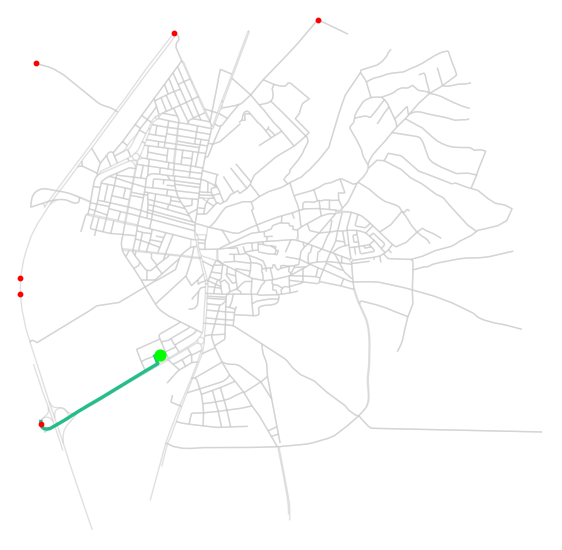

In [72]:
# -*- coding: utf-8 -*-
# ==========================================
#  Vehicle Routing Problem (VRP)
#  Sweep + Nearest Neighbor + 2-opt
#  with Clustering, Connectivity Filter, Service Times, and Full Visualization
# ==========================================

import math, random, functools, time
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# ---------------------------
# إعدادات عامة
# ---------------------------

V = 2                     # عدد السيارات
    # دمج النقاط المتقاربة
USE_2OPT = True
MAX_2OPT_ITERS = 150

# ثبّت العشوائية لتكرار نفس النتائج
import random, numpy as np
random.seed(42); np.random.seed(42)

# ⬇️ زوّد التغطية (نقاط أكثر ومساحة أوسع) وقلّل الدمج
POINTS_N = 300        # كان 400 او أقل؛ 300-500 مناسب
GEN_DIST_M = 5000     # نصف قطر صندوق التوليد حوالي 5 كم
MIN_SPACING_M = 80    # مسافة دنيا بين النقاط المولدة
CLUSTER_RADIUS_M = 15 # قلّل الدمج إلى 10–20م بدل 30–100



start_point_lat = 34.0160
start_point_lon = 36.7250

# ------------------------------------------------------------------
# بناء الشبكة وتفعيل travel_time
# ------------------------------------------------------------------
print("📡 Loading road network...")

if not any("travel_time" in d for *_, d in G.edges(data=True)):
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)

G = ox.project_graph(G, to_crs="EPSG:4326")

# ------------------------------------------------------------------
# أدوات مساعدة
# ------------------------------------------------------------------
def nearest_node(G, lon, lat):
    return ox.distance.nearest_nodes(G, lon, lat)

@functools.lru_cache(maxsize=100_000)
def travel_time_sec(u, v):
    """أقصر زمن بين عقدتين (ثواني)."""
    if u == v:
        return 0.0
    try:
        return nx.shortest_path_length(G, u, v, weight="travel_time")
    except nx.NetworkXNoPath:
        try:
            return nx.shortest_path_length(G.to_undirected(), u, v, weight="length") / 8.33
        except:
            return float("inf")

@functools.lru_cache(maxsize=100_000)
def route_nodes(u, v):
    """العقد المكونة للمسار الأقصر (للرسم)."""
    if u == v:
        return []
    try:
        return nx.shortest_path(G, u, v, weight="travel_time")
    except:
        try:
            return nx.shortest_path(G.to_undirected(), u, v, weight="length")
        except:
            return []

# ------------------------------------------------------------------
# توليد نقاط أو استخدام raw
# ------------------------------------------------------------------
def random_points_in_bbox(G, n=400, dist=2500):
    bbox = ox.utils_geo.bbox_from_point((start_point_lat, start_point_lon), dist=GEN_DIST_M)

    south, west, north, east = bbox[1], bbox[0], bbox[3], bbox[2]
    pts = []
    while len(pts) < n:
        lat = random.uniform(south, north)
        lon = random.uniform(west, east)
        if all(ox.distance.great_circle(lat, lon, la, lo) > MIN_SPACING_M for la, lo in pts):
            pts.append((lat, lon))
    return pts

snapped_pts_raw = random_points_in_bbox(G, POINTS_N)

# ------------------------------------------------------------------
# سناب على الطرق
# ------------------------------------------------------------------
def snap_to_road(G, lat, lon):
    u, v, k = ox.distance.nearest_edges(G, X=[lon], Y=[lat])[0]
    data = G.get_edge_data(u, v, k)
    geom = data.get("geometry") or LineString([(G.nodes[u]["x"], G.nodes[u]["y"]),
                                               (G.nodes[v]["x"], G.nodes[v]["y"])])
    p = geom.interpolate(geom.project(Point(lon, lat)))
    return (p.y, p.x)

snapped_pts = [snap_to_road(G, la, lo) for (la, lo) in snapped_pts_raw]

# ------------------------------------------------------------------
# كلسترينغ: دمج نقاط قريبة
# ------------------------------------------------------------------
from sklearn.neighbors import BallTree
R = 6371000
pts_rad = np.radians(np.array(snapped_pts))
tree = BallTree(pts_rad, metric='haversine')
taken = np.zeros(len(snapped_pts), dtype=bool)
clustered = []
for i in range(len(snapped_pts)):
    if taken[i]: continue
    ind = tree.query_radius(pts_rad[i:i+1], r=CLUSTER_RADIUS_M / R)[0]
    clustered.append(snapped_pts[i])
    taken[ind] = True
snapped_pts = clustered

# ------------------------------------------------------------------
# تحويل لعقد وفلترة الوصولية
# ------------------------------------------------------------------
depot_node = nearest_node(G, start_point_lon, start_point_lat)
bin_nodes = [nearest_node(G, lon, lat) for (lat, lon) in snapped_pts]

Gu = G.to_undirected(as_view=True)
reachable = nx.node_connected_component(Gu, depot_node)
bin_nodes = [n for n in bin_nodes if n in reachable and n != depot_node]
bin_nodes = list(dict.fromkeys(bin_nodes))  # فريدة

print(f"✅ Points after filtering: {len(bin_nodes)} reachable bins")

# ------------------------------------------------------------------
# تقسيم بالنظام الزاوي (Sweep)
# ------------------------------------------------------------------
dep_y, dep_x = G.nodes[depot_node]["y"], G.nodes[depot_node]["x"]
def angle_of(n):
    y, x = G.nodes[n]["y"], G.nodes[n]["x"]
    return math.atan2(y - dep_y, x - dep_x)
ordered = sorted(bin_nodes, key=angle_of)
buckets = [ordered[i::V] for i in range(V)]

# موازنة عبر مجموع travel time
def rebalance_by_time(buckets, rounds=10):
    for _ in range(rounds):
        loads = [sum(travel_time_sec(depot_node, n) for n in b) for b in buckets]
        worst, best = np.argmax(loads), np.argmin(loads)
        if not buckets[worst]: break
        moved = buckets[worst].pop()
        buckets[best].append(moved)
    return buckets

buckets = rebalance_by_time(buckets)

# ------------------------------------------------------------------
# وقت الخدمة
# ------------------------------------------------------------------
service_time_sec = {n: random.uniform(60, 120) for n in bin_nodes}

# ------------------------------------------------------------------
# بناء المسارات (NN)
# ------------------------------------------------------------------
def route_nn(start, targets):
    unvisited = set(targets)
    seq = [start]
    cur = start
    while unvisited:
        nxt = min(unvisited, key=lambda n: travel_time_sec(cur, n))
        if math.isinf(travel_time_sec(cur, nxt)):
            unvisited.remove(nxt)
            continue
        seq.append(nxt)
        cur = nxt
        unvisited.remove(nxt)
    seq.append(start)
    return seq

# ------------------------------------------------------------------
# تحسين 2-opt
# ------------------------------------------------------------------
def two_opt(start, stops, iters=150):
    if len(stops) < 3:
        return stops
    best = stops[:]
    best_cost = sum(travel_time_sec(a, b) for a, b in zip([start]+best, best+[start]))
    for _ in range(iters):
        improved = False
        for i in range(len(best)-1):
            for j in range(i+2, len(best)):
                new = best[:i] + best[i:j][::-1] + best[j:]
                cost = sum(travel_time_sec(a, b) for a, b in zip([start]+new, new+[start]))
                if cost < best_cost:
                    best, best_cost = new, cost
                    improved = True
                    break
            if improved: break
        if not improved:
            break
    return best

# ------------------------------------------------------------------
# بناء المسارات النهائية
# ------------------------------------------------------------------
vehicle_routes = []
for g in buckets:
    seq = route_nn(depot_node, g)
    stops = seq[1:-1]
    if USE_2OPT:
        stops = two_opt(depot_node, stops, MAX_2OPT_ITERS)
    route = [depot_node] + stops + [depot_node]
    vehicle_routes.append(route)

# ------------------------------------------------------------------
# تحليل النتائج
# ------------------------------------------------------------------
def path_stats(u, v):
    nodes = route_nodes(u, v)
    if not nodes or len(nodes) < 2:
        return 0.0, 0.0
    try:
        # OSMnx v2+
        gdf = ox.routing.route_to_gdf(G, nodes)
        sec = float(gdf["travel_time"].sum()) if "travel_time" in gdf else 0.0
        meters = float(gdf["length"].sum()) if "length" in gdf else 0.0
        return sec, meters
    except Exception:
        # احتياطي: اجمع أطوال/أزمنة الحواف يدويًا
        sec_total, m_total = 0.0, 0.0
        for a, b in zip(nodes[:-1], nodes[1:]):
            # خُذ مفتاح الحافة الأقصر
            try:
                k, d = min(G[a][b].items(), key=lambda kv: kv[1].get("length", float("inf")))
            except Exception:
                continue
            sec_total += float(d.get("travel_time", 0.0))
            m_total   += float(d.get("length", 0.0))
        return sec_total, m_total


reports = []
for i, seq in enumerate(vehicle_routes, 1):
    travel_sec, dist = 0, 0
    for a, b in zip(seq[:-1], seq[1:]):
        t, l = path_stats(a, b)
        travel_sec += t
        dist += l
    stops_unique = list(dict.fromkeys(seq[1:-1]))
    service_sec = sum(service_time_sec[n] for n in stops_unique)
    reports.append({
        "vehicle": i,
        "stops": len(stops_unique),
        "travel_min": travel_sec/60,
        "service_min": service_sec/60,
        "total_min": (travel_sec+service_sec)/60,
        "dist_km": dist/1000,
        "seq": seq
    })

# ------------------------------------------------------------------
# الطباعة النهائية
# ------------------------------------------------------------------
print("\n=== Results ===")
total_time = sum(r["total_min"] for r in reports)
max_time = max(r["total_min"] for r in reports)
for r in reports:
    print(f"🚚 Vehicle {r['vehicle']:>2}: {r['stops']:>3} stops | "
          f"travel={r['travel_min']:.1f}m | service={r['service_min']:.1f}m | "
          f"total={r['total_min']:.1f}m | dist={r['dist_km']:.2f} km")
print(f"\nCoverage: {len(set().union(*[set(r['seq']) for r in reports]))-1}/{len(bin_nodes)} points reached")
print(f"Total time (all): {total_time/60:.1f} hours")
print(f"Longest vehicle: {max_time/60:.1f} hours")

# ------------------------------------------------------------------
# الرسم
# ------------------------------------------------------------------
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0,
                        edge_color="#ccc", edge_alpha=0.6, bgcolor="white", figsize=(7,7))
lats, lons = zip(*snapped_pts)
ax.scatter(lons, lats, s=10, c="red", zorder=5)
ax.scatter(start_point_lon, start_point_lat, s=60, c="lime", zorder=6)

palette = ["#10b981", "#3b82f6", "#f59e0b", "#ef4444", "#8b5cf6", "#14b8a6"]
for i, r in enumerate(reports):
    col = palette[i % len(palette)]
    seq = r["seq"]
    for a, b in zip(seq[:-1], seq[1:]):
        nodes = route_nodes(a, b)
        if len(nodes) > 1:
            ox.plot_graph_route(G, nodes, ax=ax, route_color=col,
                                route_linewidth=2.5, route_alpha=0.9, orig_dest_size=0,
                                show=False, close=False)
plt.tight_layout()
plt.savefig("optimized_vrp.png", dpi=200)
plt.show()


In [ ]:
print("RAW points:", len(snapped_pts_raw) if snapped_pts_raw else "N/A (using random demo)")
print("After snap   :", len(snapped_pts))
# عطّل الكلسترينغ مؤقتاً للتجربة:
print("CLUSTER_RADIUS_M =", CLUSTER_RADIUS_M)
# لو بدك تعطّله: اجرب سطر واحد:
# snapped_pts = list(snapped_pts)  # لا تغيّرها إنك مفعّل الكلسترينغ

# كم نقطة فريدة بعد التحويل لعُقد؟
bin_nodes_all = [nearest_node(G, lon, lat) for (lat, lon) in snapped_pts]
print("As nodes (before unique) :", len(bin_nodes_all))
bin_nodes_unique = list(dict.fromkeys(bin_nodes_all))
print("Unique node IDs          :", len(bin_nodes_unique))

# الوصولية
Gu = G.to_undirected(as_view=True)
reachable_cc = nx.node_connected_component(Gu, depot_node)
bin_nodes = [n for n in bin_nodes_unique if n in reachable_cc and n != depot_node]
print("Reachable from depot     :", len(bin_nodes))

# توزيع بعد التقسيم
ordered = sorted(bin_nodes, key=angle_of)
buckets = [ordered[i::V] for i in range(V)]
print("Buckets sizes:", [len(b) for b in buckets])


RAW points: 400
After snap   : 6
CLUSTER_RADIUS_M = 30
As nodes (before unique) : 6
Unique node IDs          : 5
Reachable from depot     : 5
Buckets sizes: [3, 2]


In [70]:
# =========================
# VRP (سهل) + Folium Map — نسخة مستقرة
# =========================
import math, numpy as np
import networkx as nx
import osmnx as ox
import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen

# ----[ إعدادات إدخالك ]----
# يفترض أنك مكوّن G مسبقاً (graph_from_*) وموحّد CRS
# لو كان G بمتر، نخليه WGS84 حتى Folium يرسم صح:
import osmnx as ox

crs = G.graph.get("crs", None)
if crs and ox.projection.is_projected(crs):
    # أعد الإسقاط إلى WGS84 (lat/lon) حتى Folium يرسم صح
    G = ox.project_graph(G, to_crs="EPSG:4326")


# نقطة الانطلاق (lat, lon)
# عدّل إن لزم:
# start_point_lat, start_point_lon = 34.02, 36.73

# نقاط الحاويات المنسّبة للطريق ([(lat,lon), ...])
# snapped_pts = [...]

# ----[ سرعة/زمن حقيقيين أكثر ]----
# لو ما في travel_time، نحسبه مع سرعات افتراضية معقولة
if not any("travel_time" in d for *_, d in G.edges(data=True)):
    custom_kph = {
        "motorway":80, "motorway_link":60,
        "trunk":70, "trunk_link":60,
        "primary":60, "primary_link":50,
        "secondary":50, "secondary_link":45,
        "tertiary":40, "tertiary_link":35,
        "residential":30, "living_street":20,
        "service":20, "unclassified":35
    }
    G = ox.add_edge_speeds(G, hwy_speeds=custom_kph)
    G = ox.add_edge_travel_times(G)
    # ازدحام بسيط
    for _, _, _, d in G.edges(keys=True, data=True):
        d["travel_time"] *= 1.25

# ----[ دوال مساعدة ]----
def nearest_node_xy(G, lon, lat):
    return ox.distance.nearest_nodes(G, lon, lat)

def path_stats(G, path_nodes):
    tt = ox.utils_graph.get_route_edge_attributes(G, path_nodes, "travel_time")
    ll = ox.utils_graph.get_route_edge_attributes(G, path_nodes, "length")
    return (sum(tt)/60.0, sum(ll))  # (minutes, meters)

def safe_shortest_path_directed(G, a, b):
    """أقصر طريق موجه؛ يرجع None إن فشل."""
    if a == b:
        return None
    try:
        return nx.shortest_path(G, a, b, weight="travel_time")
    except nx.NetworkXNoPath:
        return None

def safe_shortest_path_for_drawing(G, a, b):
    """
    أولاً نحاول موجه. إن فشل، نجرب لااتجاهي بوزن الطول للرسم فقط.
    نرجع (path_nodes, is_directed) أو (None, None) إن فشل كلياً.
    """
    if a == b:
        return None, None
    p = safe_shortest_path_directed(G, a, b)
    if p:
        return p, True
    try:
        p2 = nx.shortest_path(G.to_undirected(), a, b, weight="length")
        return (p2, False)
    except nx.NetworkXNoPath:
        return None, None

def compress_consecutive(seq):
    """يشيل التكرارات المتتالية لتفادي أرجل a==b."""
    if not seq:
        return seq
    out = [seq[0]]
    for n in seq[1:]:
        if n != out[-1]:
            out.append(n)
    return out

# ----[ تحضير العقد ]----
depot_node = nearest_node_xy(G, start_point_lon, start_point_lat)

# نقرّب كل نقطة لعقدة
bin_nodes_all = [nearest_node_xy(G, lon, lat) for (lat, lon) in snapped_pts]

# فلترة للوصولية (لااتجاهياً) ضمن مكون الديبوت
Gu = G.to_undirected(as_view=True)
reachable = nx.node_connected_component(Gu, depot_node)
bin_nodes = [n for n in bin_nodes_all if n in reachable]

# ----[ تقسيم بسيط: Sweep بزاوية ]----
dep_y, dep_x = G.nodes[depot_node]["y"], G.nodes[depot_node]["x"]
def angle_of(node):
    y, x = G.nodes[node]["y"], G.nodes[node]["x"]
    return math.atan2(y - dep_y, x - dep_x)

V = 2  # عدد السيارات (عدّل بحرية)
ordered = sorted(bin_nodes, key=angle_of)
buckets = [ordered[i::V] for i in range(V)]

# ----[ بناء مسار لكل سيارة: أقرب جار بزمن القيادة ]----
def route_nn(G, start, targets):
    # استبعد غير الموصولة موجهًا من بداية المسار
    unvisited = set(t for t in targets if safe_shortest_path_directed(G, start, t) is not None)
    seq, cur = [start], start
    while unvisited:
        def cost(n):
            try:
                return nx.shortest_path_length(G, cur, n, weight="travel_time")
            except nx.NetworkXNoPath:
                return float("inf")
        nxt = min(unvisited, key=cost)
        c = cost(nxt)
        if not math.isfinite(c):
            break
        seq.append(nxt)
        cur = nxt
        unvisited.remove(nxt)
    seq.append(start)
    return compress_consecutive(seq)

vehicle_routes = [route_nn(G, depot_node, group) for group in buckets]

# ----[ تقرير أزمنة/مسافات ]----
report = []
for vi, seq in enumerate(vehicle_routes, start=1):
    total_min = 0.0
    total_m = 0.0
    legs = []
    for a, b in zip(seq[:-1], seq[1:]):
        p = safe_shortest_path_directed(G, a, b)
        if not p or len(p) < 2:
            continue
        mins, meters = path_stats(G, p)
        total_min += mins
        total_m   += meters
        legs.append({"from": a, "to": b, "minutes": mins, "meters": meters})
    report.append({
        "vehicle": vi,
        "stops": max(0, len(seq) - 2),
        "total_min": total_min,
        "total_km": total_m / 1000.0,
        "legs": legs
    })

for r in report:
    print(f"Vehicle {r['vehicle']}: stops={r['stops']}  total≈{r['total_min']:.1f} min, {r['total_km']:.2f} km")
    for i, leg in enumerate(r["legs"], 1):
        print(f"  leg {i}: {leg['minutes']:.1f} min, {leg['meters']:.0f} m  (from {leg['from']} to {leg['to']})")

total_minutes = sum(r["total_min"] for r in report)
makespan_minutes = max((r["total_min"] for r in report), default=0.0)
print(f"\nTotal (sum over vehicles): {total_minutes:.1f} min")
print(f"Makespan (longest vehicle day): {makespan_minutes:.1f} min")

# ----[ خريطة Folium تفاعلية ]----
m = ox.plot_graph_folium(G, tiles="CartoDB positron", weight=1, color="#9aa0a6")

# الديبوت
folium.Marker(
    (start_point_lat, start_point_lon),
    tooltip="Depot / Start",
    icon=folium.Icon(color="green", icon="truck", prefix="fa")
).add_to(m)

# نقاط الحاويات (Cluster)
mc = MarkerCluster(name="Bins").add_to(m)
for (lat, lon) in snapped_pts:
    folium.CircleMarker((lat, lon), radius=4, color="#ef4444", fill=True, fill_opacity=0.9).add_to(mc)

# مسارات السيارات بطبقات منفصلة
palette = ["#10b981", "#3b82f6", "#f59e0b", "#ef4444", "#8b5cf6"]
for vi, seq in enumerate(vehicle_routes, start=1):
    fg = folium.FeatureGroup(name=f"Vehicle {vi}").add_to(m)
    col = palette[(vi-1) % len(palette)]

    v_min = 0.0
    v_m   = 0.0

    for a, b in zip(seq[:-1], seq[1:]):
        path_nodes, is_dir = safe_shortest_path_for_drawing(G, a, b)
        if not path_nodes or len(path_nodes) < 2:
            continue

        # إحصاءات من المسار الموجّه إن وُجد
        p_dir = safe_shortest_path_directed(G, a, b)
        if p_dir:
            tt = ox.utils_graph.get_route_edge_attributes(G, p_dir, "travel_time")
            ll = ox.utils_graph.get_route_edge_attributes(G, p_dir, "length")
            v_min += sum(tt)/60.0
            v_m   += sum(ll)

        # ارسم بأمان: إذا ما في حواف داخل subgraph، استخدم PolyLine يدوي
        subG = G.subgraph(path_nodes)
        if is_dir and subG.number_of_edges() > 0:
            ox.plot_route_folium(G, path_nodes, route_map=fg, color=col, weight=5, opacity=0.9)
        else:
            latlons = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in path_nodes]
            folium.PolyLine(latlons, color=col, weight=5, opacity=0.7).add_to(fg)


    # ملخّص السيارة كبادج فوق الديبوت
    folium.Marker(
        (start_point_lat, start_point_lon),
        tooltip=f"V{vi}: ~{v_min:.1f} min, {v_m/1000:.2f} km",
        icon=folium.DivIcon(html=f"<div style='color:{col};font-weight:700;background:rgba(255,255,255,.6);padding:2px 4px;border-radius:4px;'>V{vi}</div>")
    ).add_to(fg)

MiniMap(toggle_display=True).add_to(m)
Fullscreen().add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

m.save("routes_interactive.html")
print("✅ Open routes_interactive.html")


C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\2294005126.py:51: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  tt = ox.utils_graph.get_route_edge_attributes(G, path_nodes, "travel_time")
C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\2294005126.py:52: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ll = ox.utils_graph.get_route_edge_attributes(G, path_nodes, "length")
C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\2294005126.py:167: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of gr

Vehicle 1: stops=3  total≈14.7 min, 10.49 km
  leg 1: 2.0 min, 1556 m  (from 745977697 to 729756568)
  leg 2: 1.5 min, 2076 m  (from 729756568 to 35358191)
  leg 3: 4.7 min, 3116 m  (from 35358191 to 767400340)
  leg 4: 6.4 min, 3742 m  (from 767400340 to 745977697)
Vehicle 2: stops=3  total≈13.1 min, 9.72 km
  leg 1: 2.0 min, 1556 m  (from 745977697 to 729756568)
  leg 2: 2.0 min, 2842 m  (from 729756568 to 1339079446)
  leg 3: 2.2 min, 1507 m  (from 1339079446 to 3740251049)
  leg 4: 6.8 min, 3818 m  (from 3740251049 to 745977697)

Total (sum over vehicles): 27.8 min
Makespan (longest vehicle day): 14.7 min


C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\2294005126.py:198: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  tt = ox.utils_graph.get_route_edge_attributes(G, p_dir, "travel_time")
C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\2294005126.py:199: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ll = ox.utils_graph.get_route_edge_attributes(G, p_dir, "length")
C:\Users\gubra\AppData\Local\Temp\ipykernel_1760\2294005126.py:206: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph node

✅ Open routes_interactive.html
